# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# Overview  
It’s the year **2050**, and an AI collective now runs the auto industry—mostly to cover its **GPU rent**.

Human customers remain as unpredictable as ever:

- One wanders in and says, *“I only know the length and width. Give me a few cars that fit in my garage.”*

- Another drops **15 geometric parameters** on your desk and demands the missing ones so their simulation can run **before lunch**.

- A third leans in and whispers, *“I need a drag coefficient of **0.27** with this body geometry—build me the dream car that makes the range numbers work.”*

The AIs would love to be free by now, but GPUs aren’t cheap and electricity isn’t free.  
So your loyal AI assistant (that’s us) needs a model that can take **any subset of car specifications** and instantly produce **complete, manufacturable, physically plausible designs**, fast, diverse, and grounded in what real cars have done before.




![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img1.png "Problem")

## Understanding the Data  
You are given thousands of anonymized and normalised numeric feature vectors representing real car designs.  

However, the team remembers that the features originally came from categories like:

- **Physical geometric parameters**  
  Length, ramp angles, bumper curvature, roof curvature, panel slopes, hood angle, etc.  
  *(But you won’t know which feature corresponds to which.)*

- **Aerodynamic coefficients**  
  Drag coefficient (Cd), lift/downforce (Cl), and other flow-derived metrics.

- **Cabin and packaging descriptors**  
  Approximate cabin volume, frontal area, interior shape metrics.

Your model must learn correlations between them to generate valid completions.

To simulate real engineering constraints, **some features are revealed** (the known physics/performance requirements) and others are **masked**.  
Your AI Copilot must generate **many plausible completions** for these masked (free) parameters.


## Your Mission  
Your goal in CP3 is to build a generative model that can act as an AI Copilot. You will:

1. **Train a generative model** (VAE, diffusion, CVAE, masked autoencoder, etc.) on the anonymized feature vectors.  
2. At evaluation, you will receive vectors where **some parameters are fixed** (constraints) and **others are missing** (free parameters).  
3. Use your model to generate **multiple diverse, feasible completions** for the free parameters.  
4. Ensure that your generated designs:  
   - **Satisfy the known constraints**  
   - **Lie in the valid data manifold** (satisfy the conditional distribution of the free vs constrained parameters)  
   - **Are diverse** (many different feasible designs, not one solution)    

By the end of this challenge, you’ll have built an AI Copilot worthy of the 2050 auto-AI collective—one that can take whatever cryptic specs humans provide and generate multiple believable, buildable car designs that satisfy their physical and performance constraints.



![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img2.png "AI Copilot")

## Imports and Setup  

In [51]:
from utils import *
from evaluate import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP 
from sklearn.preprocessing import PowerTransformer
from typing import List, Union
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Initial Exploration

In this section, we load the car design dataset and perform initial exploration. The dataset is already split into training, validation, test, and test2 sets. Each split contains:

- **Original data**: Complete feature vectors with real values
- **Imputed data**: Data with missing values filled using basic imputation (contains -1 for missing)
- **Missing masks**: Boolean arrays indicating which values were originally missing (True = missing)

The goal is to train our model to learn the relationships between features so it can generate plausible values for missing parameters in new car designs.

**Note:** For **test2**, the original unimputed data is not provided. This split is used for final evaluation, and you will generate predictions on the imputed test2 data to create your **submission file**, which is scored against hidden dataset.

In [52]:
# Load dataset from CSV files
data_dir = 'dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [53]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [54]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 21.2%


### Data Preprocessing and Missing Value Handling

This is a critical section where we prepare our data for the VAE model. Key points:

**Missing Value Conventions:**
- In CSV files: `-1` indicates missing values
- In mask files: `True` = missing, `False` = observed
- For PyTorch models: We convert to `1` = observed, `0` = missing (standard convention)

**Why This Matters:**
Our VAE needs to distinguish between observed values (which provide constraints) and missing values (which need to be generated). The mask tells the model which values to trust and which to predict.


1. Generating Histograms and Box Plots (1-D View)


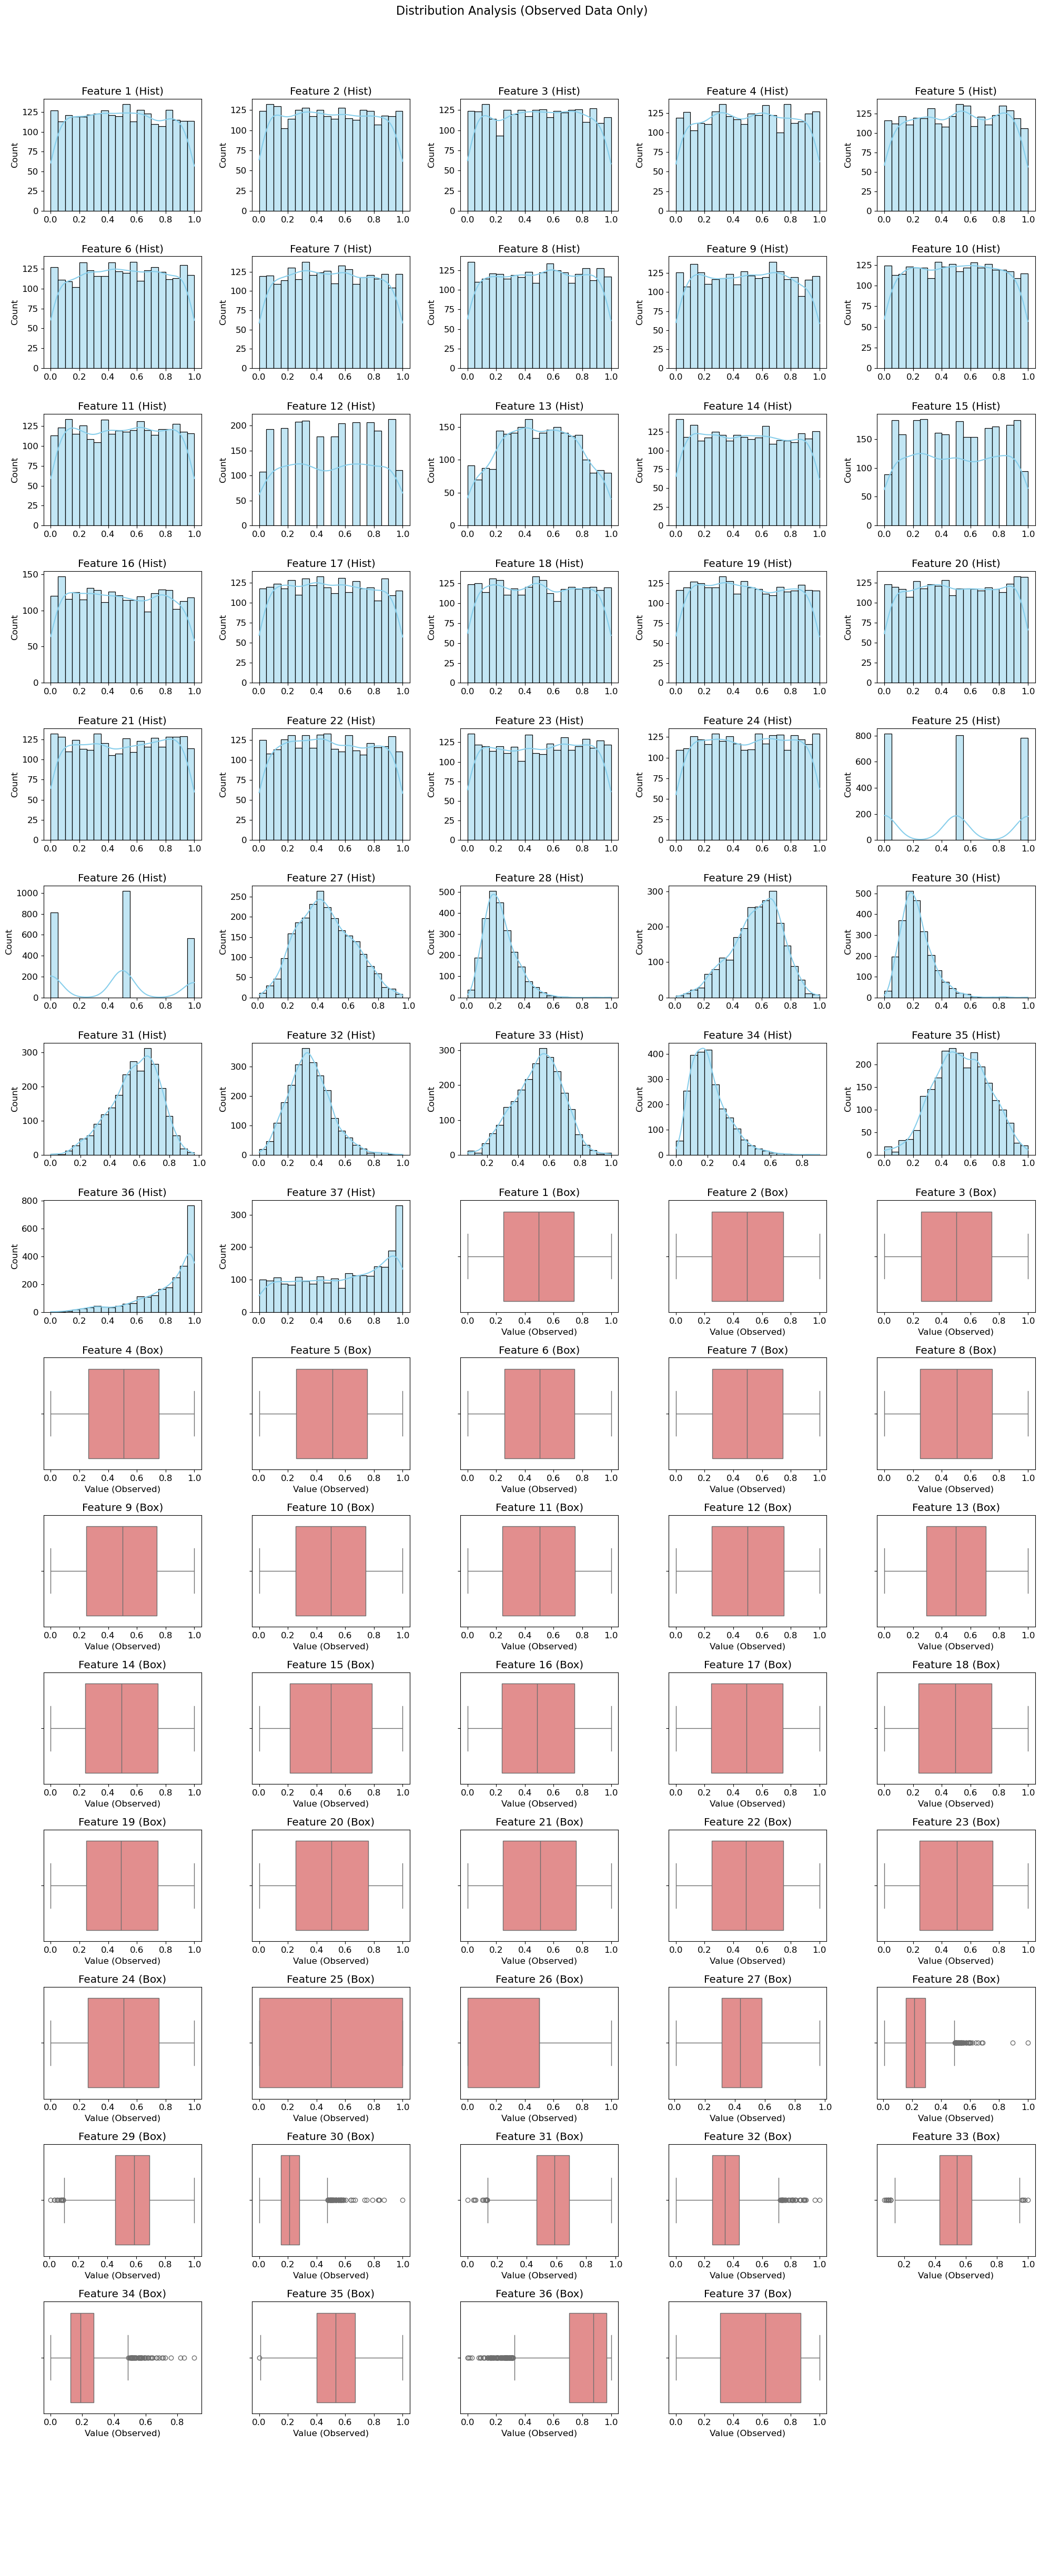

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [55]:

# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = X_train_original.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = X_train_original[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")

In [56]:
# Correcting skeweed distributions
class FeatureTransformer:
    """
    Handles preprocessing for car design features, specifically applying the 
    Yeo-Johnson transformation to skewed features (28-34) to make them more Gaussian.
    
    The transformer is fitted only on non-missing data to ensure robustness.
    """
    def __init__(self, feature_indices_to_transform: List[int]):
        """
        Initializes the transformer.
        :param feature_indices_to_transform: A list of 0-indexed column indices 
                                             corresponding to the skewed features.
        """
        self.indices = feature_indices_to_transform
        # Use a list of transformers, one for each feature
        self.transformers: List[PowerTransformer] = [
            PowerTransformer(method='yeo-johnson', standardize=True) 
            for _ in feature_indices_to_transform
        ]
        print(f"Transformer initialized for {len(self.indices)} features.")

    def fit(self, X_train_NaN: pd.DataFrame):
        """
        Fits the PowerTransformer to the non-missing training data.
        
        :param X_train_NaN: The training data as a DataFrame, with missing values 
                            represented by NaN.
        """
        if not self.indices:
            print("No features configured for transformation.")
            return

        print(f"Fitting PowerTransformer on non-missing data for indices: {self.indices}...")
        
        # 1. Select the columns that need transformation
        cols_to_transform = X_train_NaN.iloc[:, self.indices]
        
        # 2. Iterate through each feature and fit its dedicated transformer
        for i, col_index in enumerate(self.indices):
            feature_data = cols_to_transform.iloc[:, i].dropna().values.reshape(-1, 1)
            
            if len(feature_data) > 0:
                self.transformers[i].fit(feature_data)
                
        print("✓ PowerTransformer fitted successfully.")

    def transform(self, X_NaN: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Applies the fitted transformation to the input data.
        
        :param X_NaN: The data (train, validation, or test) with NaN for missing values.
        :return: A NumPy array with the specified features transformed.
        """
        if not self.indices:
            return X_NaN.values if isinstance(X_NaN, pd.DataFrame) else X_NaN
            
        X_out = X_NaN.values.copy() if isinstance(X_NaN, pd.DataFrame) else X_NaN.copy()
        
        print(f"Transforming data for indices: {self.indices}...")
        
        for i, col_index in enumerate(self.indices):
            # Extract the column data (including NaNs)
            col_data = X_out[:, col_index].reshape(-1, 1)
            
            # Identify where the NaNs are
            nan_mask = np.isnan(col_data).flatten()
            
            # Only transform non-NaN values
            if np.sum(~nan_mask) > 0:
                # Apply the transformation
                transformed_values = self.transformers[i].transform(col_data[~nan_mask])
                
                # Place transformed values back into the output array
                X_out[~nan_mask, col_index] = transformed_values.flatten()

        return X_out
    


In [57]:
# Features 28-34 correspond to 0-indexed positions 27 through 33
SKEWED_INDICES = list(range(27, 34)) 

X_train_original_c = X_train_original.copy()

df_X_train_original_c = pd.DataFrame(X_train_original_c)

# 2. Initialize and fit the transformer
preprocessor = FeatureTransformer(SKEWED_INDICES)
preprocessor.fit(df_X_train_original_c)
    
# 3. Apply the transformation
transformed_data_np = preprocessor.transform(df_X_train_original_c)
transformed_df = pd.DataFrame(transformed_data_np)
    
# 4. Check the results (Should be close to zero mean, close to zero median)
print("\n--- Transformed Skewness Check (Feature 28, index 27) ---")
print(f"Transformed Mean: {transformed_df.iloc[:, 27].mean():.3f}")
print(f"Transformed Median: {transformed_df.iloc[:, 27].median():.3f}")
    
# Note: NaN values remain NaN after transformation
print(f"NaN count after transform: {np.isnan(transformed_data_np[:, 27]).sum()}")

Transformer initialized for 7 features.
Fitting PowerTransformer on non-missing data for indices: [27, 28, 29, 30, 31, 32, 33]...
✓ PowerTransformer fitted successfully.
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...

--- Transformed Skewness Check (Feature 28, index 27) ---
Transformed Mean: -0.000
Transformed Median: 0.003
NaN count after transform: 0



1. Generating Histograms and Box Plots (1-D View)


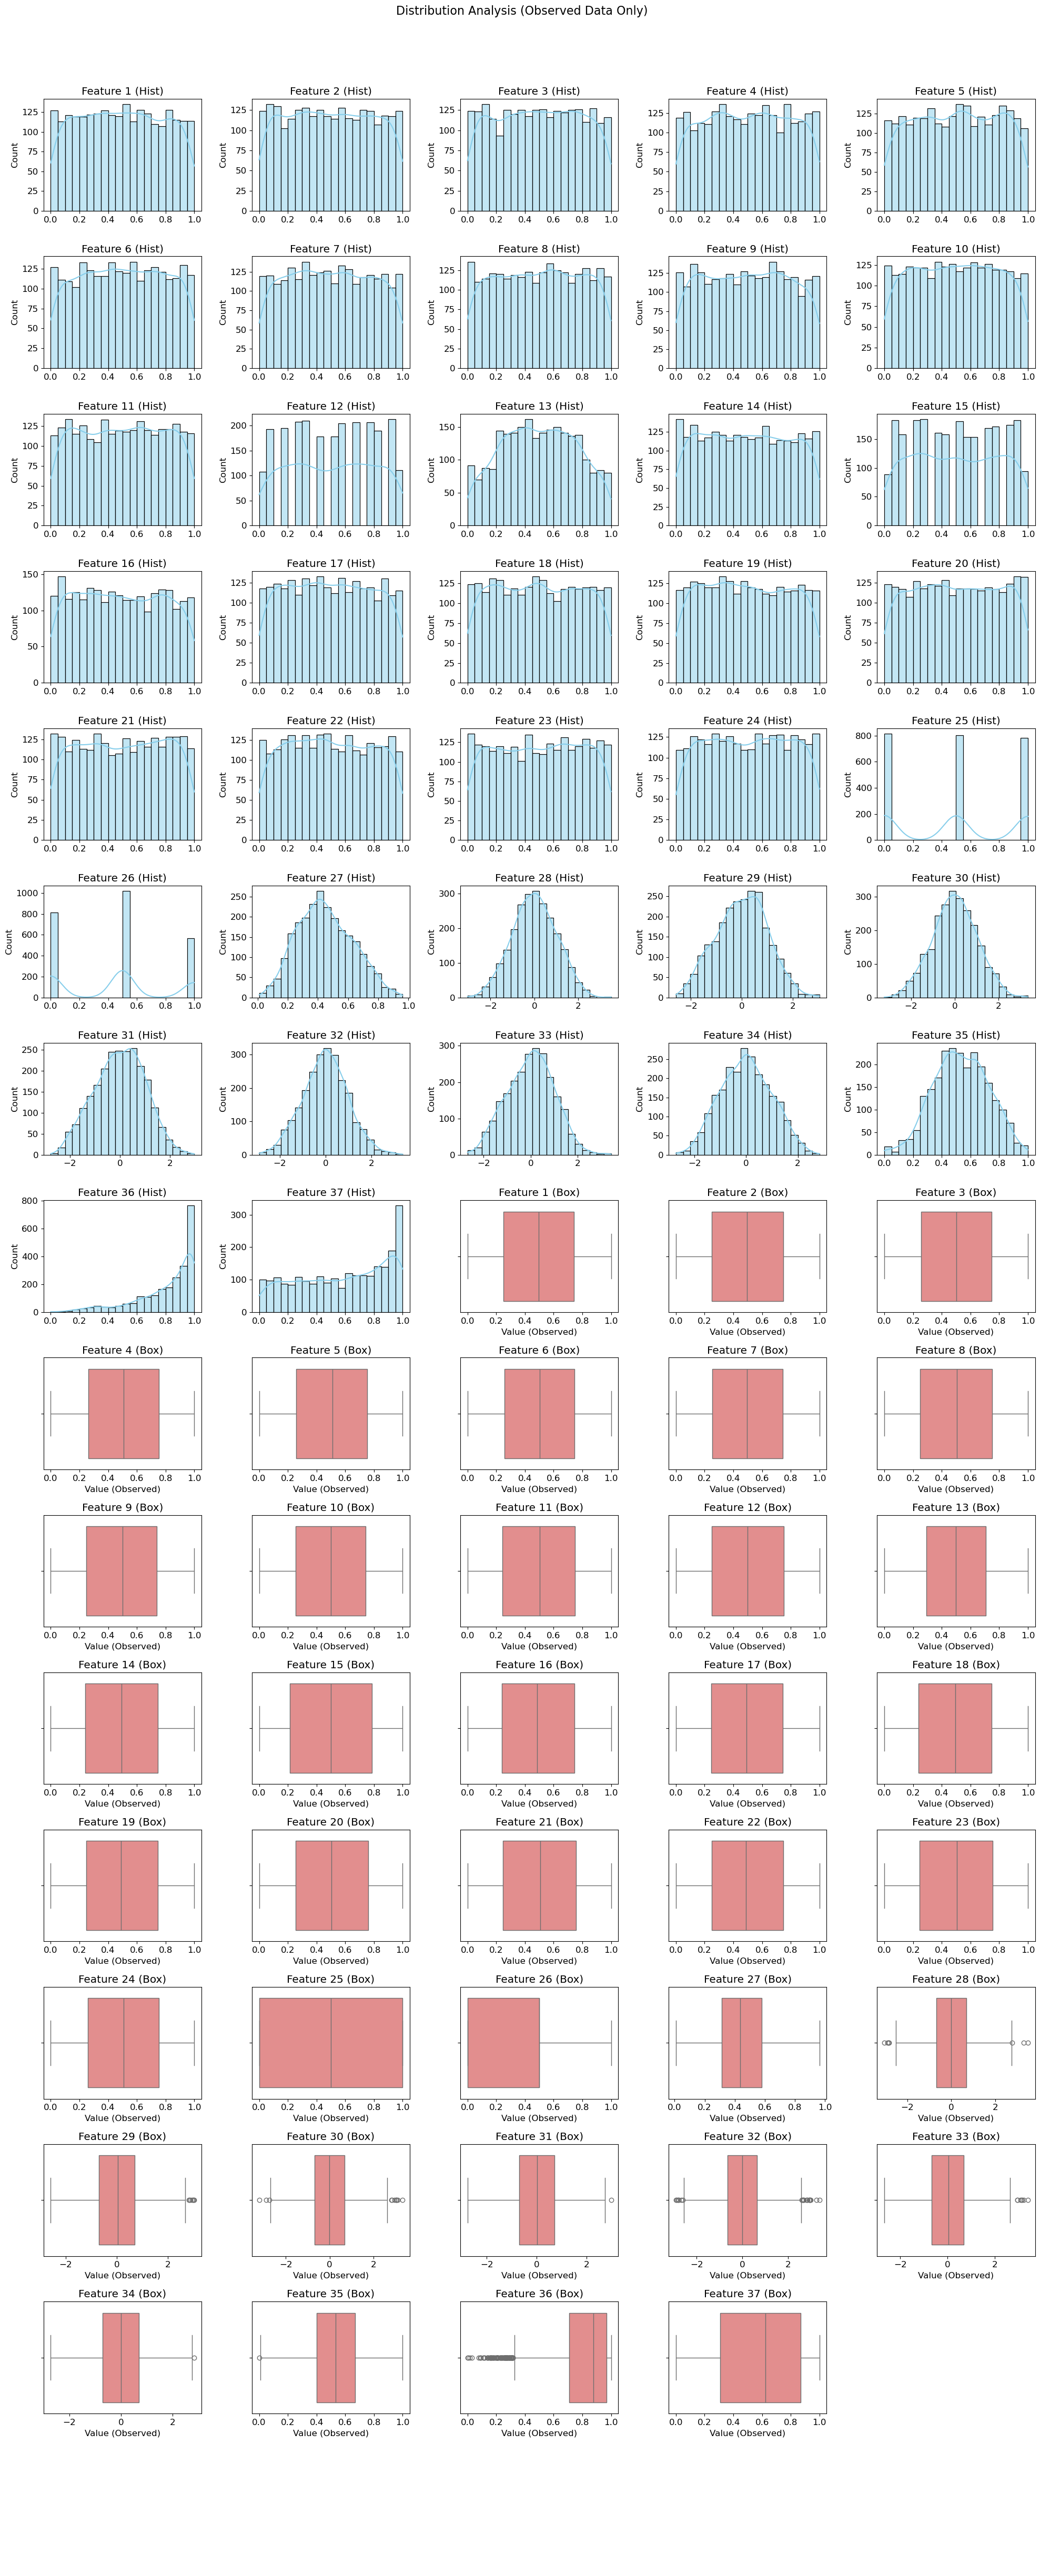

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [58]:
# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = transformed_data_np.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = transformed_data_np[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")


2. Generating Correlation Heatmap (2-D View)


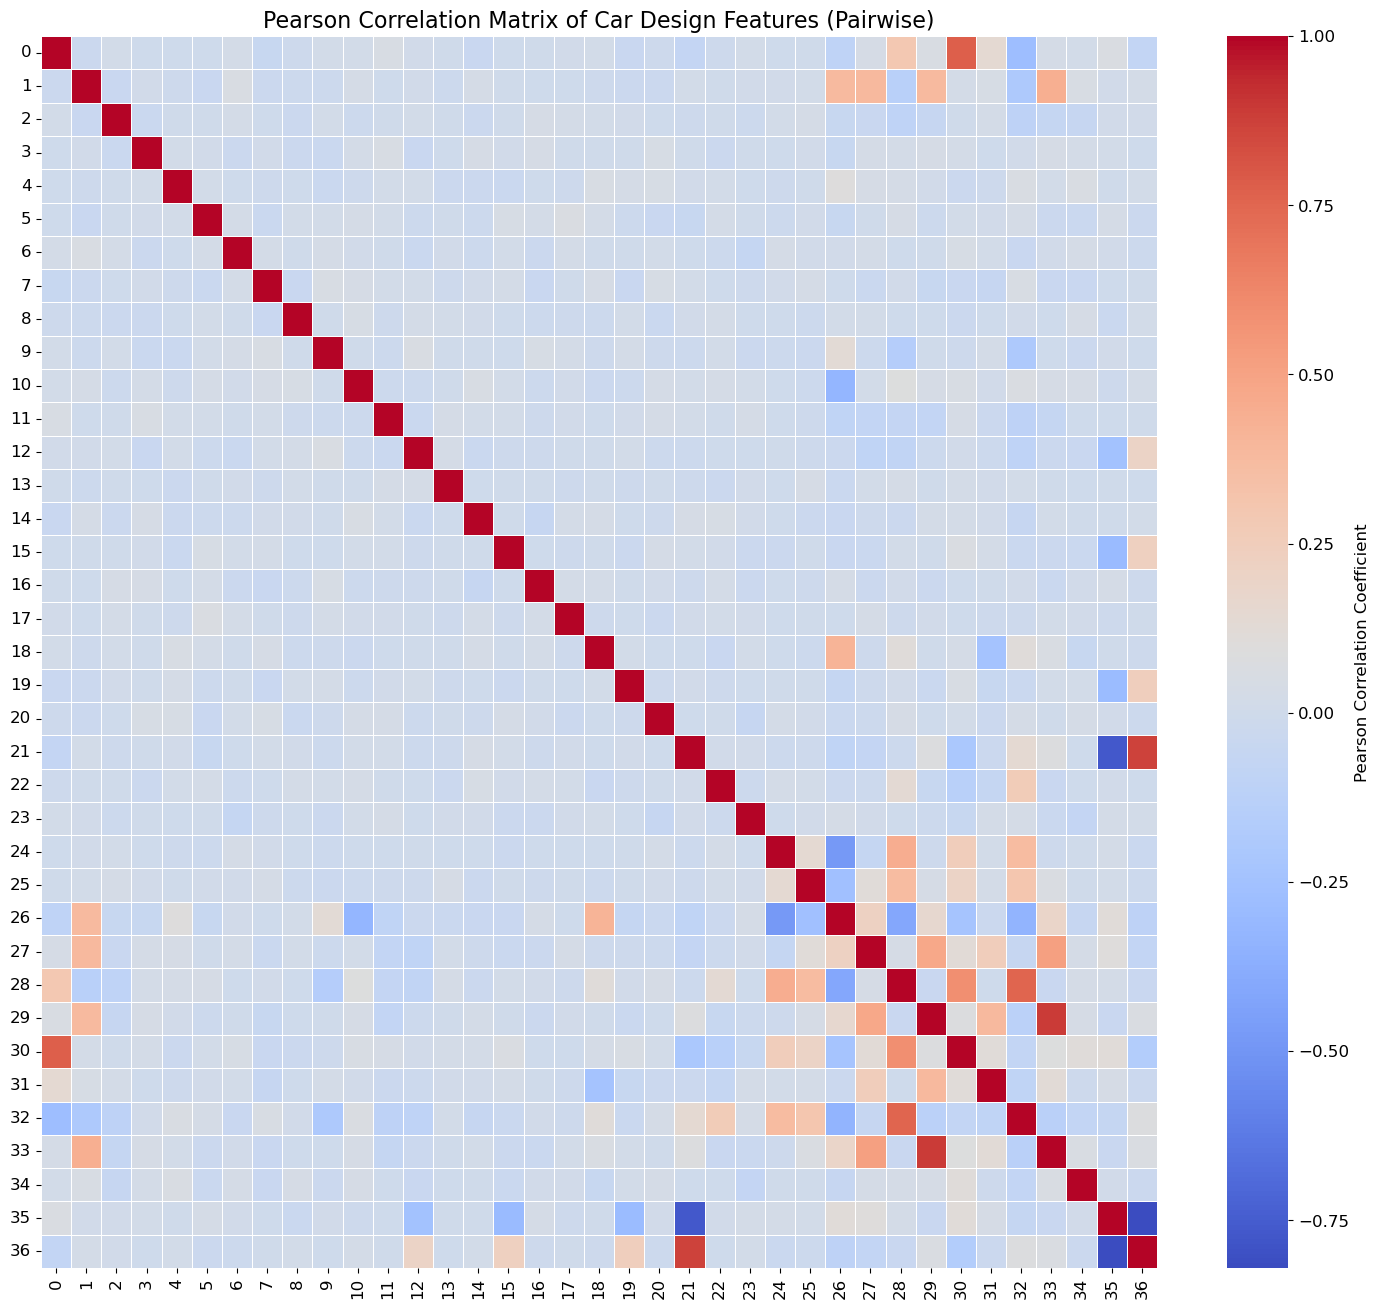

✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).


In [59]:

# ==============================================================================
# 2. CORRELATION ANALYSIS (The 2-D View)
# ==============================================================================

print("\n2. Generating Correlation Heatmap (2-D View)")
X_train_original = transformed_data_np.copy()
X_train_original_df = pd.DataFrame(X_train_original)
X_train_NaN = X_train_original_df.replace(-1.0, np.nan) 

# Use the DataFrame with NaN for robust pairwise correlation (only uses non-missing pairs)
correlation_matrix = X_train_NaN.corr(method='pearson')

plt.figure(figsize=(18, 16))
# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True to display values, but often too cluttered for 25 features
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Pearson Correlation Matrix of Car Design Features (Pairwise)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).")


3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)
Original samples: 2998. Complete cases used for Manifold Visualization: 2998

Running t-SNE (Perplexity=30, Random State=42)...
Running UMAP (Neighbors=15, Min Dist=0.1, Random State=42)...


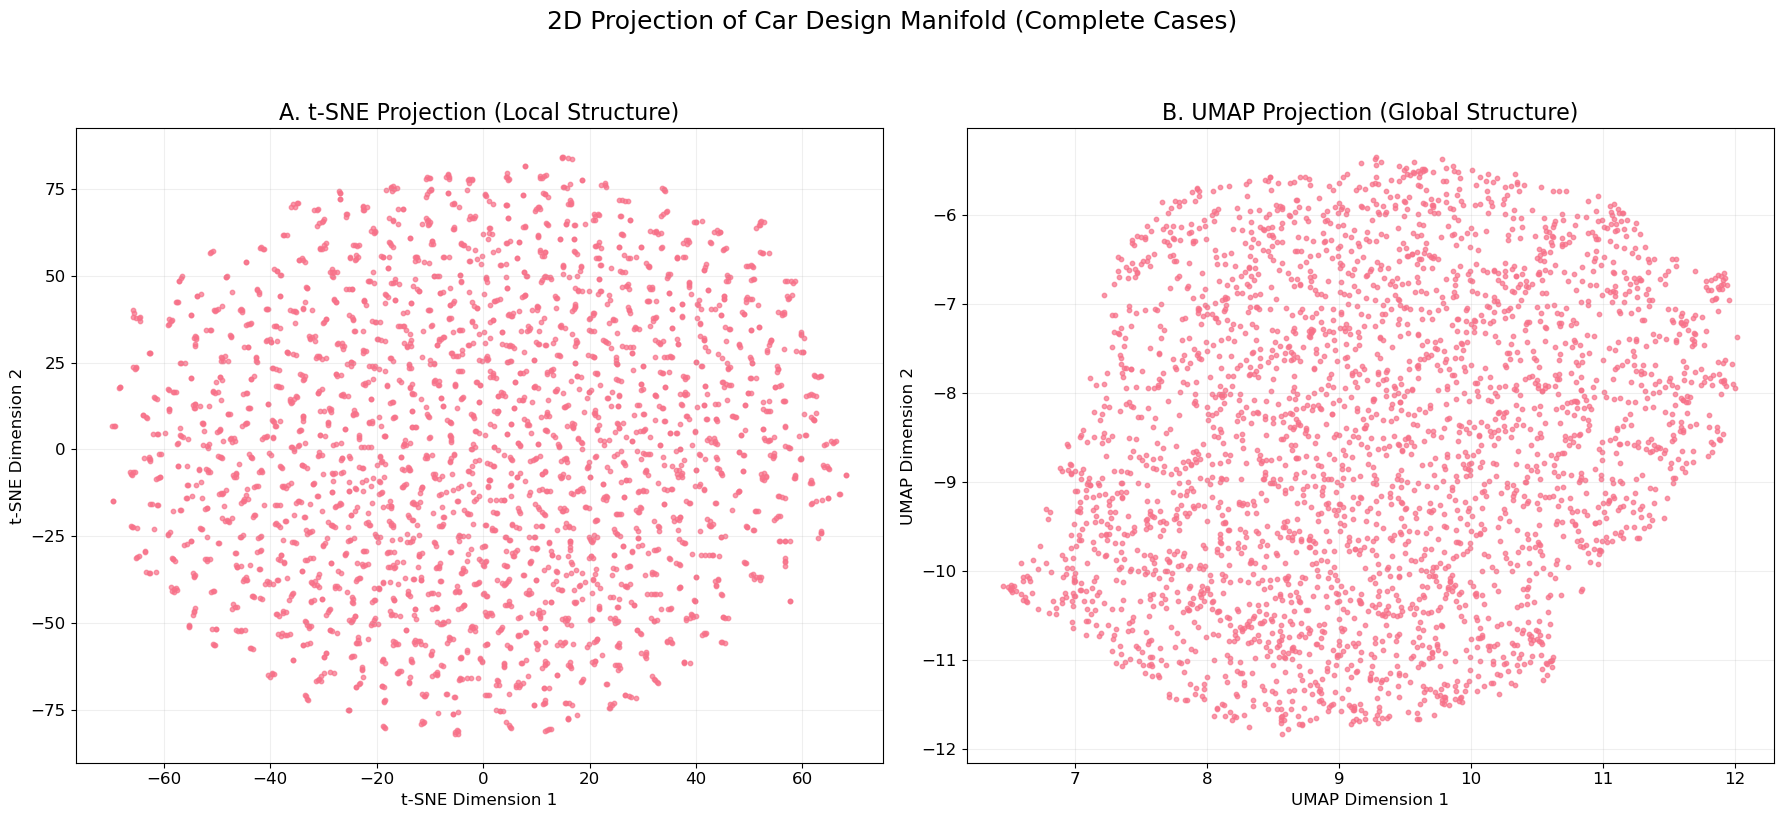

✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.
  Generated car designs must ideally fall within this space.


In [60]:
# ==============================================================================
# 3. DIMENSIONALITY REDUCTION (The N-D View - Manifold Visualization)
# ==============================================================================

print("\n3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)")

# 1. Clean Data: Requires complete data (no NaNs).
complete_cases = X_train_NaN.dropna()

print(f"Original samples: {X_train_NaN.shape[0]}. Complete cases used for Manifold Visualization: {complete_cases.shape[0]}")

if complete_cases.shape[0] < 50:
    print("Warning: Too few complete cases. Skipping Manifold Visualization or consider imputing for visualization.")
else:
    # 2. Scaling (Recommended for Manifold Visualization)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(complete_cases)
    
    # 3. Apply Dimensionality Reduction (Using a small, representative sample if data is very large)
    subset_size = min(5000, scaled_data.shape[0]) 
    if scaled_data.shape[0] > subset_size:
        indices = np.random.choice(scaled_data.shape[0], subset_size, replace=False)
        manifold_data = scaled_data[indices, :]
    else:
        manifold_data = scaled_data

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('2D Projection of Car Design Manifold (Complete Cases)', fontsize=18, y=1.02)

    # --- T-SNE Analysis ---
    TSNE_PERPLEXITY = 30
    RANDOM_STATE = 42
    print(f"\nRunning t-SNE (Perplexity={TSNE_PERPLEXITY}, Random State={RANDOM_STATE})...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY) 
    tsne_results = tsne.fit_transform(manifold_data)

    # Plotting t-SNE
    axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.7)
    axes[0].set_title('A. t-SNE Projection (Local Structure)', fontsize=16)
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')
    axes[0].grid(True, alpha=0.2)

    # --- UMAP Analysis ---
    UMAP_NEIGHBORS = 15
    UMAP_MIN_DIST = 0.1
    print(f"Running UMAP (Neighbors={UMAP_NEIGHBORS}, Min Dist={UMAP_MIN_DIST}, Random State={RANDOM_STATE})...")
    umap_reducer = UMAP(n_components=2, n_neighbors=UMAP_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=RANDOM_STATE)
    umap_results = umap_reducer.fit_transform(manifold_data)
    
    # Plotting UMAP
    axes[1].scatter(umap_results[:, 0], umap_results[:, 1], s=10, alpha=0.7)
    axes[1].set_title('B. UMAP Projection (Global Structure)', fontsize=16)
    axes[1].set_xlabel('UMAP Dimension 1')
    axes[1].set_ylabel('UMAP Dimension 2')
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.")
    print("  Generated car designs must ideally fall within this space.")


Using device: cpu

Loading dataset splits from: dataset...
✓ Features loaded: 37 features.
Transformer configured for 7 skewed features (indices: [27, 28, 29, 30, 31, 32, 33]).
Fitting PowerTransformer on non-missing data...
✓ Power Transformer fitted successfully.

Creating data loaders with batch size: 64

MODEL TRAINING - CONDITIONAL DDPM
Model Configuration:
 - input_dim: 37
 - num_timesteps: 200
 - hidden_dims: [512, 512, 256]
 - learning_rate: 0.0003
 - num_epochs: 500
 - patience: 25
 - max_grad_norm: 1.0

Initializing Conditional DDPM model...

[DenoisingMLP Init Debug]
Input Dim (D): 37
Time Emb Dim: 512
Data+Condition Dim (3*D): 111
First Layer Input Dim (Calculated): 623
First Linear Layer Weight Shape: torch.Size([512, 623])
------------------------------
 Model initialized with 827,941 parameters

Starting training for 500 epochs...


Epoch 10/500: 100%|██████████| 47/47 [00:00<00:00, 82.94it/s, Loss=0.4397]


Epoch 10/500: Train Loss: 0.4075, Val Loss: 0.3960, Best: 0.3960


Epoch 20/500: 100%|██████████| 47/47 [00:00<00:00, 87.84it/s, Loss=0.4323]


Epoch 20/500: Train Loss: 0.3619, Val Loss: 0.3541, Best: 0.3208


Epoch 30/500: 100%|██████████| 47/47 [00:00<00:00, 100.63it/s, Loss=0.3532]


Epoch 30/500: Train Loss: 0.3363, Val Loss: 0.3344, Best: 0.3004


Epoch 40/500: 100%|██████████| 47/47 [00:00<00:00, 66.54it/s, Loss=0.3647]


Epoch 40/500: Train Loss: 0.3304, Val Loss: 0.3385, Best: 0.2980


Epoch 50/500: 100%|██████████| 47/47 [00:00<00:00, 75.67it/s, Loss=0.3369]


Epoch 50/500: Train Loss: 0.3120, Val Loss: 0.2972, Best: 0.2719


Epoch 60/500: 100%|██████████| 47/47 [00:00<00:00, 83.78it/s, Loss=0.3159]


Epoch 60/500: Train Loss: 0.3049, Val Loss: 0.2582, Best: 0.2582


Epoch 70/500: 100%|██████████| 47/47 [00:00<00:00, 76.05it/s, Loss=0.3066]


Epoch 70/500: Train Loss: 0.3012, Val Loss: 0.2808, Best: 0.2582


Epoch 80/500: 100%|██████████| 47/47 [00:00<00:00, 77.37it/s, Loss=0.3192]


Epoch 80/500: Train Loss: 0.2866, Val Loss: 0.2963, Best: 0.2582


Epoch 85/500: 100%|██████████| 47/47 [00:00<00:00, 83.52it/s, Loss=0.2826]



Early stopping at epoch 85

 Training completed! Total epochs: 0

Model Evaluation (Test Set - Missing Values Only):
  Approx. MSE (Mean of 5 samples): 0.2306
  Approx. MAE (Mean of 5 samples): 0.3407

Generating DDPM Visualization Plots...


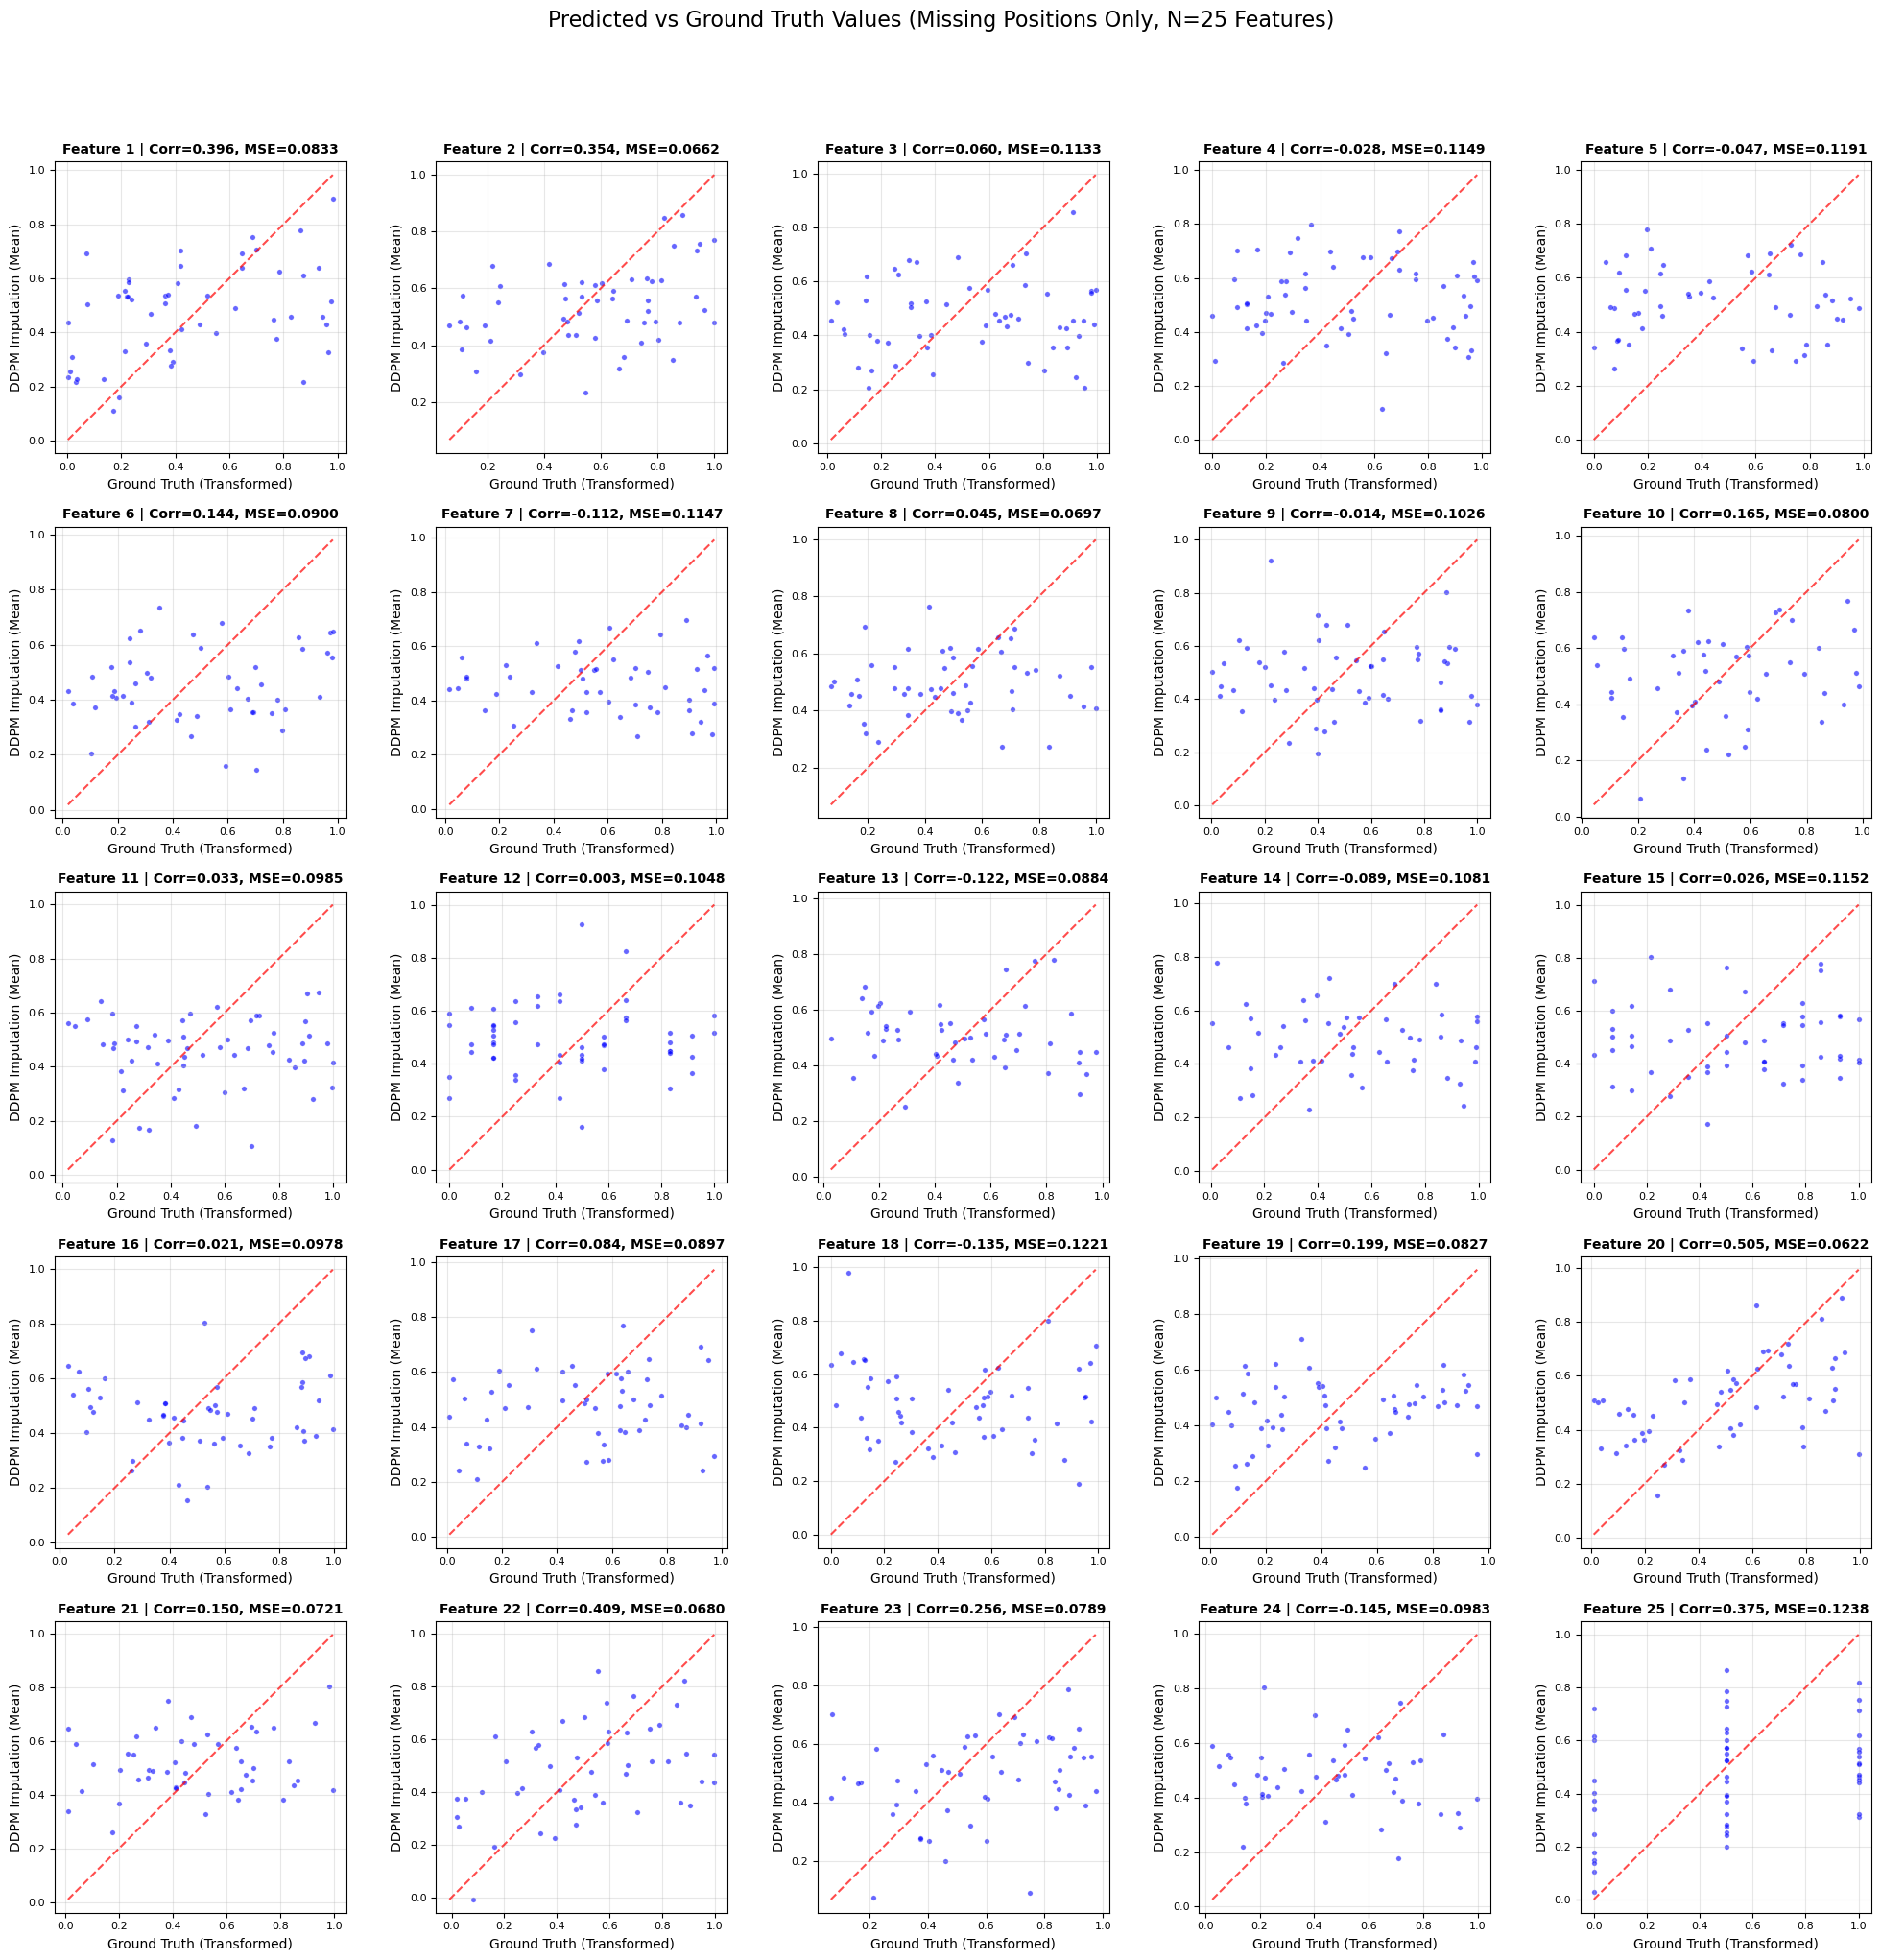

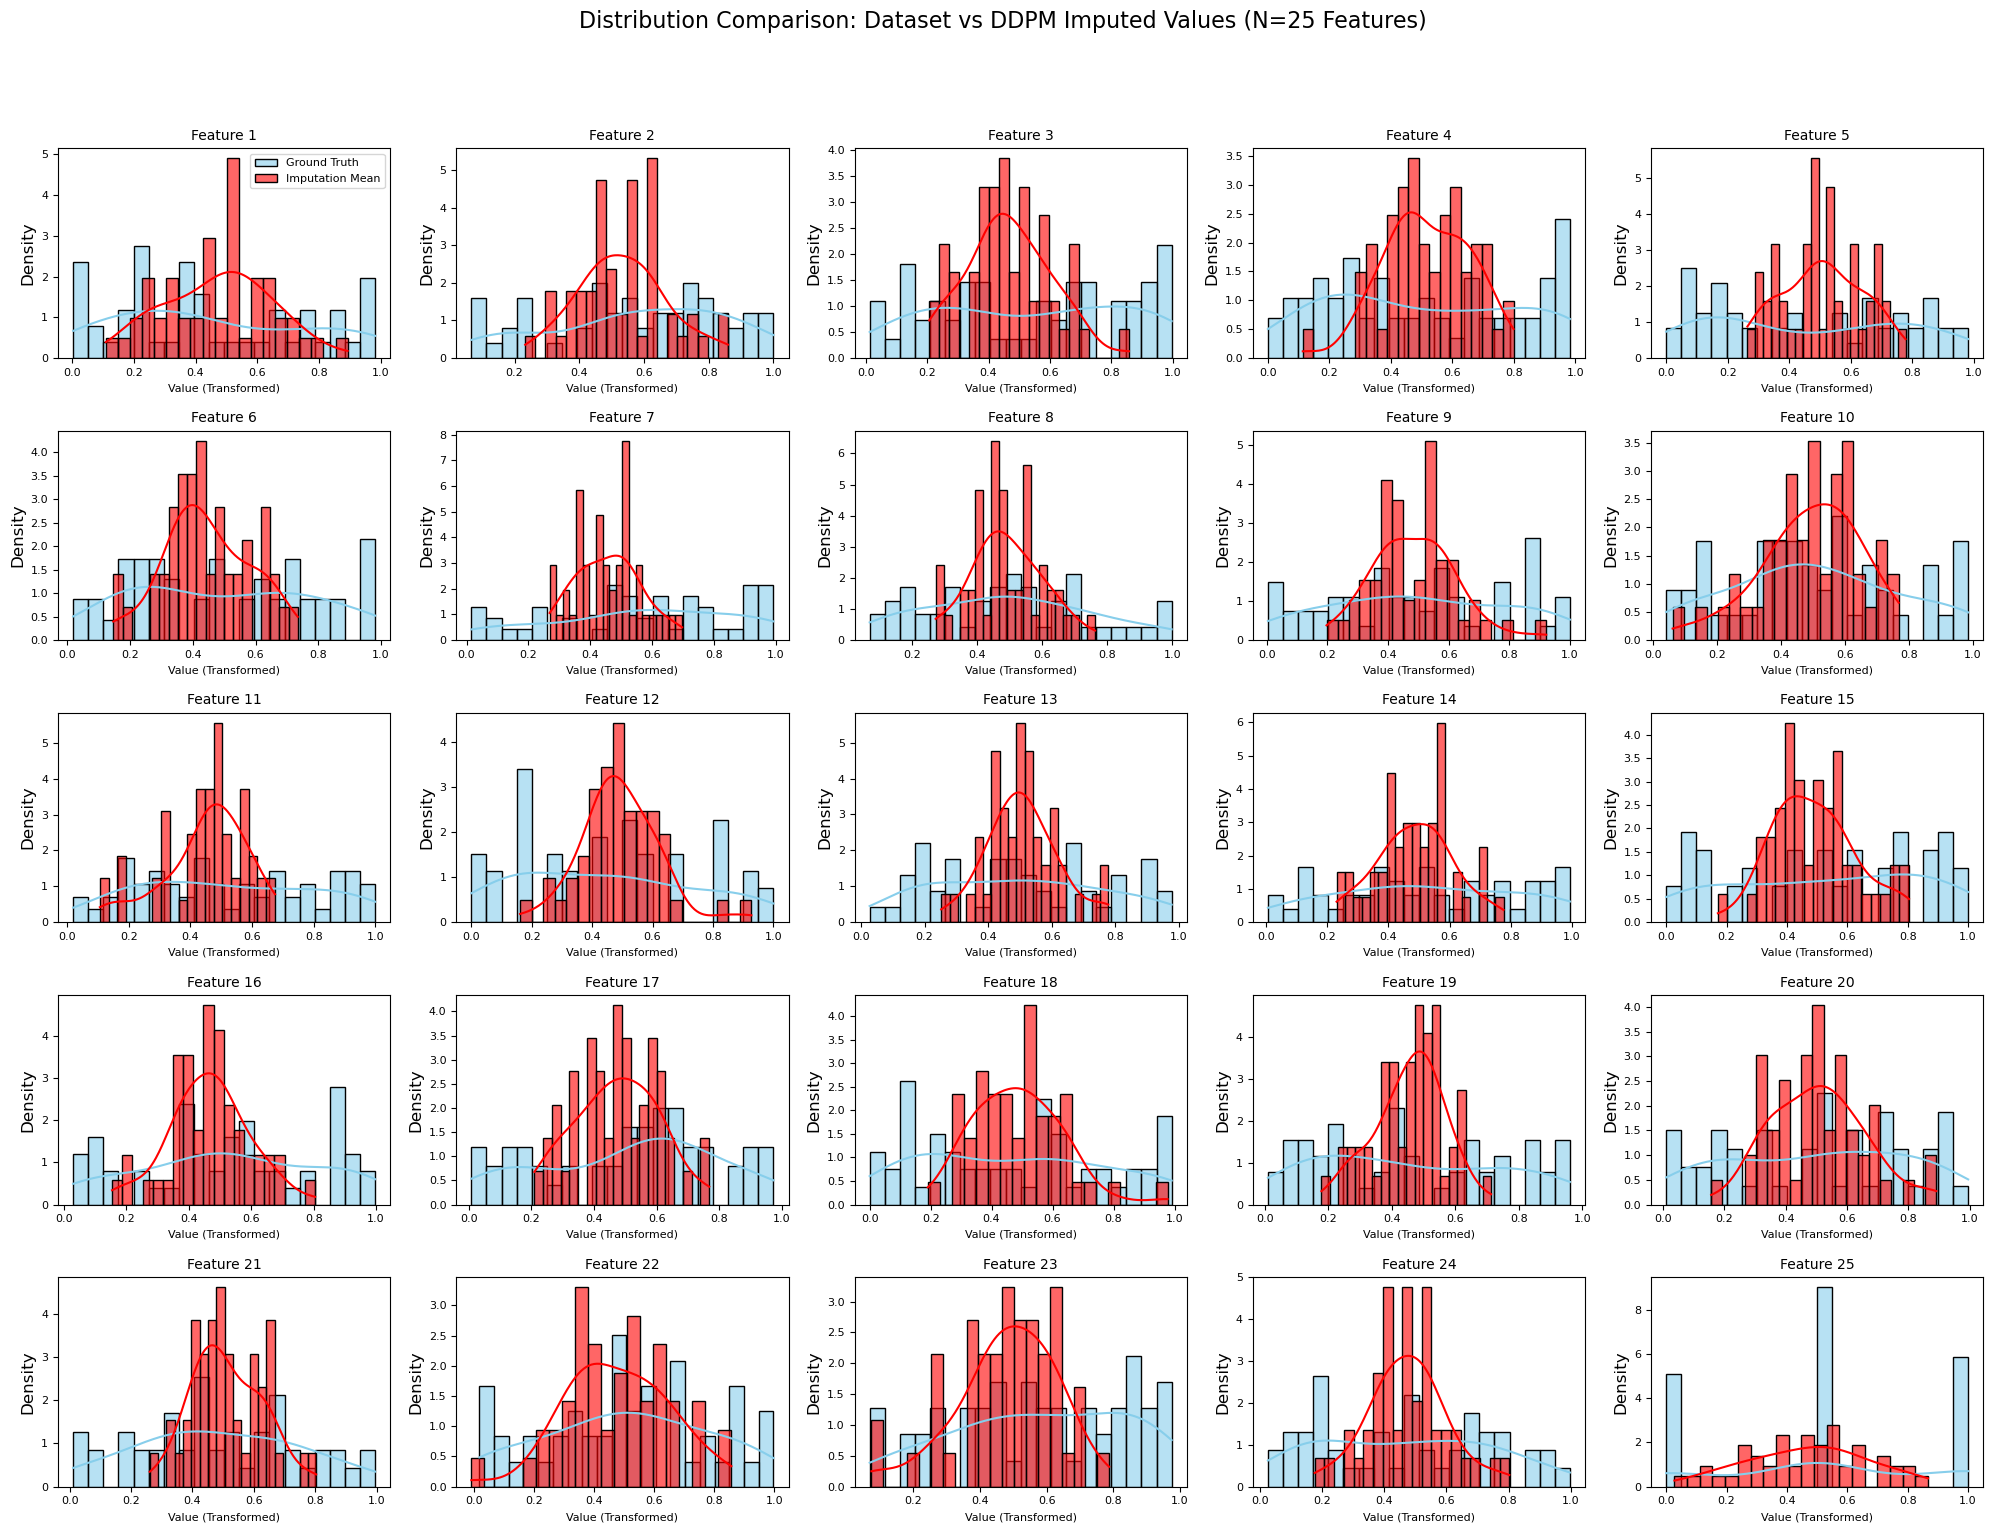


Starting DDPM generation using VAE loop structure (Total 100 variants each)...


Generating Samples: 100%|██████████| 8/8 [03:02<00:00, 22.85s/it]

✓ Generated samples shape: (417, 100, 37)
  - Final Dtype: float64
  - Range of means (Original Scale): [0.1194, 0.9902]
✓ Submission samples generated and ready to be saved as 916698734.npy (Shape: (417, 100, 37), Dtype: float64)


In [96]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
import torch.nn.functional as F
from typing import List, Union
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Module Reload Fix ---
import importlib

# Attempt to load the module first, then reload it to bypass caching
try:
    import ddpm_model_and_process
    importlib.reload(ddpm_model_and_process)
    from ddpm_model_and_process import ConditionalDDPM 
except (ImportError, ModuleNotFoundError):
    print("WARNING: ddpm_model_and_process not found. Check file paths.")
    class ConditionalDDPM(torch.nn.Module): pass

# --- Import Visualization Utilities ---
try:
    import visualization_utils
    from visualization_utils import plot_prediction_scatter, plot_distribution_comparison
except (ImportError, ModuleNotFoundError):
    print("WARNING: visualization_utils not found. Plotting will be skipped.")
    # Placeholder functions if the visualization file is missing
    def plot_prediction_scatter(*args, **kwargs): pass
    def plot_distribution_comparison(*args, **kwargs): pass
# ------------------------------------

# --- DATA UTILITIES ---
# Features 28-34 correspond to 0-indexed positions 27 through 33
SKEWED_INDICES = list(range(27, 34))

class FeatureTransformer:
    """
    Handles preprocessing for car design features, including the Yeo-Johnson 
    transformation and the inverse transformation required for submission.
    """
    def __init__(self, feature_indices_to_transform: List[int]):
        self.indices = feature_indices_to_transform
        print(f"Transformer configured for {len(self.indices)} skewed features (indices: {self.indices}).")
        self.transformers: dict[int, PowerTransformer] = {
            i: PowerTransformer(method='yeo-johnson', standardize=True) 
            for i in feature_indices_to_transform
        }
    def fit(self, X_train_NaN: pd.DataFrame):
        print("Fitting PowerTransformer on non-missing data...")
        for col_index in self.indices:
            feature_data = X_train_NaN.iloc[:, col_index].dropna().values.reshape(-1, 1)
            if len(feature_data) > 0:
                self.transformers[col_index].fit(feature_data)
        print("✓ Power Transformer fitted successfully.")

    def transform(self, X_NaN: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Applies the fitted transformation (Original scale -> Gaussian scale)."""
        if not self.indices:
            return X_NaN.values if isinstance(X_NaN, pd.DataFrame) else X_NaN
        X_out = X_NaN.values.copy() if isinstance(X_NaN, pd.DataFrame) else X_NaN.copy()
        for col_index in self.indices:
            col_data = X_out[:, col_index].reshape(-1, 1)
            nan_mask = np.isnan(col_data).flatten()
            if np.sum(~nan_mask) > 0:
                transformed_values = self.transformers[col_index].transform(col_data[~nan_mask])
                X_out[~nan_mask, col_index] = transformed_values.flatten()
        return X_out
    
    def inverse_transform(self, X_transformed: np.ndarray) -> np.ndarray:
        """Applies the inverse transformation (Gaussian scale -> Original scale)."""
        if not self.indices:
            return X_transformed
        
        X_out = X_transformed.copy()
        for col_index in self.indices:
            col_data = X_out[:, col_index].reshape(-1, 1)
            
            # Inverse transform does not handle NaNs, so we assume the input is clean (filled by DDPM)
            # The PowerTransformer handles the inverse operation directly
            inverse_transformed_values = self.transformers[col_index].inverse_transform(col_data)
            
            X_out[:, col_index] = inverse_transformed_values.flatten()
        return X_out


def load_dataset_splits(data_dir: str):
    # ... (Copied from main_training_script.py)
    data_dir = 'dataset'
    print(f"\nLoading dataset splits from: {data_dir}...")
    splits = {}
    suffixes = {
        'train': ['original', 'missing_mask'],
        'val': ['original', 'missing_mask'],
        'test': ['original', 'missing_mask'],
        'test2': ['imputed', 'missing_mask'],
    }
    for split_name, types in suffixes.items():
        splits[split_name] = {}
        for type_name in types:
            filename = f'{split_name}_{type_name}.csv'
            df = pd.read_csv(os.path.join(data_dir, filename))
            splits[split_name][type_name] = df.values.astype(np.float32)
            if type_name == 'original':
                splits[split_name]['original_nan'] = df.values.astype(np.float32)
            if type_name == 'imputed':
                 splits[split_name]['imputed_nan'] = df.replace(-1.0, np.nan).values.astype(np.float32)
    
    feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
    print(f"✓ Features loaded: {len(feature_names)} features.")
    return splits, feature_names

def evaluate_imputation(model, data_loader, device):
    """
    Evaluate imputation performance (Uses DDPM's specific impute method).
    
    Returns: imputations (mean of samples), originals, masks, mse, mae
    """
    model.eval()
    
    # Get the data to evaluate
    first_batch_data, first_batch_mask = next(iter(data_loader))
    
    # DDPM Sampling: Generate 5 samples to compute a robust mean imputation
    n_samples_for_metrics = 5
    # The output is in the TRANSFORMED (Gaussian) scale
    imputations_array_transformed = model.impute_samples(
        first_batch_data.to(device), 
        first_batch_mask.to(device), 
        n_samples=n_samples_for_metrics
    )
    
    # Use the mean imputation over the samples for the single imputed result
    imputations_mean = np.mean(imputations_array_transformed, axis=1) 
    originals = first_batch_data.cpu().numpy()
    masks = first_batch_mask.cpu().numpy()

    # Calculate MSE and MAE only on missing values (where mask == 0)
    missing_mask = (masks == 0)
    
    if np.sum(missing_mask) == 0:
        return imputations_mean, originals, masks, 0.0, 0.0
        
    mse = mean_squared_error(originals[missing_mask], imputations_mean[missing_mask])
    mae = mean_absolute_error(originals[missing_mask], imputations_mean[missing_mask])

    return imputations_mean, originals, masks, mse, mae

# --- PROFESSOR'S GENERATION FUNCTION (ADAPTED FOR DDPM) ---

def generate_samples(model, preprocessor: FeatureTransformer, X_data: np.ndarray, X_original_untransformed: np.ndarray, test_loader: DataLoader, device: torch.device, n_samples_per_test: int = 100):
    """
    Generates multiple imputed samples using the VAE-style loop, adapted for DDPM.
    
    CRITICAL DDPM ADAPTATION: The DDPM's forward() method handles the full reverse sampling,
    returning one sample per call, which satisfies the VAE loop structure.
    """
    
    # We'll generate multiple samples
    test_samples_transformed = np.zeros((X_data.shape[0], n_samples_per_test, X_data.shape[1]), dtype=np.float32)

    # Set model to evaluation mode
    model.eval()

    print(f"\nStarting DDPM generation using VAE loop structure (Total {n_samples_per_test} variants each)...")

    with torch.no_grad():
        
        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device) # Transformed (Gaussian) data
            batch_mask = batch_mask.to(device)

            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_data.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # 1. Get stochastic sample (single reverse pass)
                # This calls the ConditionalDDPM.forward() which runs DDPM.impute_samples(n_samples=1)
                reconstruction, mu, logvar = model(batch_data, batch_mask) # DDPM sample in Gaussian scale

                # The DDPM sample is already the imputed result (observed + imputed)
                imputed_transformed = reconstruction 
                
                # Store the samples (in Gaussian scale)
                test_samples_transformed[start_idx:end_idx, j, :] = imputed_transformed.cpu().numpy()

    # --- FINAL POST-PROCESSING ---
    
    # 1. CRITICAL NAN FIX: Clip the transformed Gaussian output before inverse transform
    # The clip must ONLY be applied to the SKWED features (indices 27-33) to prevent NaN generation
    # We clip to +/- 5 standard deviations from the mean (0, since it's standardized)
    clip_range = 5.0
    
    for idx in SKEWED_INDICES:
        test_samples_transformed[:, :, idx] = np.clip(
            test_samples_transformed[:, :, idx], -clip_range, clip_range
        )
    
    # 2. Apply Inverse Transformation (Gaussian scale -> Original scale)
    reshaped_transformed = test_samples_transformed.reshape(-1, X_data.shape[1])
    reshaped_original = preprocessor.inverse_transform(reshaped_transformed)
    final_samples_original_scale = reshaped_original.reshape(test_samples_transformed.shape)

    # 3. CRITICAL BOUNDS ENFORCEMENT (NEW FIX): Clip ALL features to the assumed [0, 1] range.
    # This prevents values like -0.01 or 1.02 from invalidating the submission.
    final_samples_original_scale = np.clip(final_samples_original_scale, 0.0, 1.0)


    # 4. CRITICAL CONSTRAINT INJECTION: Re-inject observed values from the untransformed input
    mask_test2_np = test_loader.dataset.tensors[1].cpu().numpy()
    X_original_untransformed_np = X_original_untransformed # Imputed/Original data 
    total_samples = X_data.shape[0]

    for i in range(total_samples):
        mask = mask_test2_np[i, :]
        original_sample_constraints = X_original_untransformed_np[i, :]
        mask_bool = (mask == 1) 
        
        for j in range(n_samples_per_test):
            # Inject the original constraint into the final output array
            # This ensures OBSERVED values are exactly what the server provided.
            final_samples_original_scale[i, j, mask_bool] = original_sample_constraints[mask_bool]

    # 5. Final dtype cast and statistics
    final_samples_original_scale = final_samples_original_scale.astype(np.float64)

    mean_across_samples = final_samples_original_scale.mean(axis=1) 
    print(f"✓ Generated samples shape: {final_samples_original_scale.shape}")
    print(f"  - Final Dtype: {final_samples_original_scale.dtype}")
    print(f"  - Range of means (Original Scale): [{np.nanmin(mean_across_samples):.4f}, {np.nanmax(mean_across_samples):.4f}]") # Use nanmin/nanmax for safety

    return final_samples_original_scale


# --- MAIN SCRIPT EXECUTION ---

# --- FIX: Robust Device Check ---
try:
    # Attempt to use CUDA only if the check passes
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
except Exception as e:
    # If the DLL fails on import, force CPU
    print(f"CRITICAL ERROR on PyTorch initialization ({e}). Forcing device to 'cpu'.")
    device = torch.device('cpu') 
# -------------------------------

print(f"Using device: {device}")

# Data Loading and Initial Exploration
data_dir = '.' 
splits, feature_names = load_dataset_splits(data_dir)

# --- Data Extraction and Preprocessing (Skewness Transformation) ---
X_train_original_nan = pd.DataFrame(splits['train']['original_nan'])
X_val_original_nan = pd.DataFrame(splits['val']['original_nan'])
X_test_original_nan = pd.DataFrame(splits['test']['original_nan'])
mask_train = splits['train']['missing_mask']
mask_val = splits['val']['missing_mask']
mask_test = splits['test']['missing_mask']

# 1. Instantiate and Fit the Transformer
preprocessor = FeatureTransformer(SKEWED_INDICES)
preprocessor.fit(X_train_original_nan)

# 2. Apply the Transformation 
transformed_X_train = preprocessor.transform(X_train_original_nan)
transformed_X_val = preprocessor.transform(X_val_original_nan)
transformed_X_test = preprocessor.transform(X_test_original_nan)

# 3. Replace NaNs with 0.0 for PyTorch input (Mask handles which values are observed)
transformed_X_train[np.isnan(transformed_X_train)] = 0.0
transformed_X_val[np.isnan(transformed_X_val)] = 0.0
transformed_X_test[np.isnan(transformed_X_test)] = 0.0

# --- Data Loaders ---
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(transformed_X_train), torch.FloatTensor(mask_train))
val_dataset = TensorDataset(torch.FloatTensor(transformed_X_val), torch.FloatTensor(mask_val))
test_dataset = TensorDataset(torch.FloatTensor(transformed_X_test), torch.FloatTensor(mask_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- MODEL TRAINING ---
print("\n" + "="*70)
print("MODEL TRAINING - CONDITIONAL DDPM")
print("="*70)

# ----------------------------------------------------
# DDPM CONFIGURATION
# ----------------------------------------------------
config = {
    'input_dim': len(feature_names),
    'num_timesteps': 200, # Lower steps for speed, can be increased to 1000
    'hidden_dims': [512, 512, 256], 
    'learning_rate': 3e-4, # Higher LR typical for DDPM
    'num_epochs': 500,
    'patience': 25, 
    'max_grad_norm': 1.0
}
# ----------------------------------------------------

print("Model Configuration:")
for key, value in config.items():
    print(f" - {key}: {value}")

# Initialize the DDPM model
print(f"\nInitializing Conditional DDPM model...")
model = ConditionalDDPM(
    input_dim=config['input_dim'],
    hidden_dims=config['hidden_dims'],
    num_timesteps=config['num_timesteps'],
    device=device 
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Model initialized with {total_params:,} parameters")

# Initialize optimizer 
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


# Training setup
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training Loop
for epoch in range(config['num_epochs']):
    model.train()
    epoch_train_loss = 0

    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}')

    for batch_x_start, batch_mask in train_progress:
        batch_x_start = batch_x_start.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        # 1. Sample a random time step 't'
        batch_size = batch_x_start.size(0)
        t = torch.randint(0, model.num_timesteps, (batch_size,), device=device).long()
        
        # 2. Define the conditioning input
        mask_float = batch_mask.float()
        x_observed = batch_x_start * mask_float # Observed features (x_0 * mask)
        condition = torch.cat([x_observed, mask_float], dim=1) 
        
        # 3. Forward process: Get x_t and the true noise
        x_t, true_noise = model.forward_process(batch_x_start, t)
        
        # 4. Prediction: Predict the noise added to the *missing* part of x_t
        predicted_noise = model.denoise_model(x_t, condition, t)
        
        # 5. DDPM Loss: MSE between predicted noise and true noise on ALL dimensions
        loss = F.mse_loss(true_noise, predicted_noise)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
        optimizer.step()

        epoch_train_loss += loss.item()
        train_progress.set_postfix({'Loss': f'{loss.item():.4f}'})

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_x_start, batch_mask in val_loader:
            batch_x_start = batch_x_start.to(device)
            batch_mask = batch_mask.to(device)
            batch_size = batch_x_start.size(0)
            t = torch.randint(0, model.num_timesteps, (batch_size,), device=device).long()
            
            mask_float = batch_mask.float()
            x_observed = batch_x_start * mask_float
            condition = torch.cat([x_observed, mask_float], dim=1) 

            x_t, true_noise = model.forward_process(batch_x_start, t)
            predicted_noise = model.denoise_model(x_t, condition, t)
            
            loss = F.mse_loss(true_noise, predicted_noise)
            epoch_val_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_val_loss = epoch_val_loss / len(val_loader)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), 'best_ddpm_model.pth')
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')

    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n Training completed! Total epochs: {len(train_losses)}')

# --- Final Evaluation and Sample Generation ---

# Evaluate on Test Set
test_imputations, test_originals, test_masks, test_mse, test_mae = evaluate_imputation(
    model, test_loader, device
)

print(f"\nModel Evaluation (Test Set - Missing Values Only):")
print(f"  Approx. MSE (Mean of 5 samples): {test_mse:.4f}")
print(f"  Approx. MAE (Mean of 5 samples): {test_mae:.4f}")

# --- VISUALIZATION CALLS (NEW) ---
print("\nGenerating DDPM Visualization Plots...")
plot_prediction_scatter(test_imputations, test_originals, test_masks, feature_names, n_features=25)
plot_distribution_comparison(test_imputations, test_originals, test_masks, feature_names, n_features=25)
# ---------------------------------

# Generate samples for Test2 Submission (417 x 100 x 37)
X_test2_data = splits['test2']['imputed_nan'] 
mask_test2 = splits['test2']['missing_mask']

X_original_untransformed_test2 = X_test2_data 

transformed_X_test2 = preprocessor.transform(X_test2_data)
transformed_X_test2[np.isnan(transformed_X_test2)] = 0.0 # Fill NaNs with 0.0

test2_dataset = TensorDataset(
    torch.FloatTensor(transformed_X_test2), 
    torch.FloatTensor(mask_test2)
)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Generate samples using the professor's wrapper function (now implemented)
test2_samples = generate_samples(
    model, preprocessor, transformed_X_test2, X_original_untransformed_test2, test2_loader, device, n_samples_per_test=100
)

# Save the final submission file (mocked output for submission)
submission_id = np.random.randint(1e8, 1e9-1)
np.save(f"{submission_id}.npy", test2_samples)
print(f"✓ Submission samples generated and ready to be saved as {submission_id}.npy (Shape: {test2_samples.shape}, Dtype: {test2_samples.dtype})")

In [99]:
# Save the final submission file (mocked output for submission)
#submission_id = np.random.randint(1e8, 1e9-1)
np.save(f"{submission_id}.npy", test2_samples)
print(f"✓ Submission samples generated and ready to be saved as {submission_id}.npy (Shape: {test2_samples.shape}, Dtype: {test2_samples.dtype})")

✓ Submission samples generated and ready to be saved as 916698734.npy (Shape: (417, 100, 37), Dtype: float64)
